In [2]:
from datetime import date, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf        
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
warnings.filterwarnings('ignore')

days_before=6400   #How many days back i want to download
start_date = (date.today()-timedelta(days=(days_before))).isoformat() 

In [10]:
# Helper functions to be able more easily replicate experiments

def data_prep(ticker):
    # Download full historical data for the ticker
    full_data = yf.download(ticker, start=start_date)

    # Filter and select relevant columns
    data = full_data[['High', 'Low', 'Open', 'Adj Close', 'Volume']]

    # Compute log returns of the adjusted closing prices
    data['returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift())

    # Compute log changes in volume
    data['volumeGap'] = np.log(data['Volume'] / data['Volume'].shift())

    # Compute daily change in price as a percentage of opening price
    data['dailyChange'] = (data['Adj Close'] - data['Open']) / data['Open']

    # Compute fraction of daily high relative to opening price
    data['fractHigh'] = (data['High'] - data['Open']) / data['Open']

    # Compute fraction of daily low relative to opening price
    data['fractLow'] = (data['Open'] - data['Low']) / data['Open']

    # Compute forecast variable as the difference between next day's adjusted closing price and today's
    data['forecastVariable'] = data['Adj Close'].shift(-1) - data['Adj Close']

    # Drop rows with missing values
    data.dropna(inplace=True)

    # Remove rows with NaN, inf, or -inf values
    data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

    # Return preprocessed data
    return data


def pre_process_plot(data, name):
    # Create a figure with two subplots
    fig, axs = plt.subplots(nrows=2, figsize=(10, 10))

    # Plot the histogram of returns in the first subplot
    axs[0].hist(data['returns'], bins=50)
    axs[0].set_title(f"{name}'s Histogram of Returns")

    # Plot the line chart of returns in the second subplot
    axs[1].plot(data['returns'])
    axs[1].set_title('Line Chart of Returns')

    # Add axis labels and title to the figure
    fig.suptitle(f'{name} Returns Data', fontsize=16)
    axs[0].set_xlabel('Returns')
    axs[0].set_ylabel('Frequency')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Returns')

    # Print descriptive statistics of the returns
    print(data['returns'].describe().T)

    # Display the plot
    plt.show()


# Define function to plot CUSUM statistic for returns data
def CUSUM_test_plot(data, name):
    # Extract returns data and create time variable
    y = data['returns']
    X = add_constant(np.arange(len(y)))
    
    # Fit linear regression model to returns data
    model = OLS(y, X)
    results = model.fit()
    
    # Compute the CUSUM statistic
    cumsum = np.cumsum(results.resid)

    # Plot the CUSUM statistic
    plt.plot(cumsum)
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.title(f'CUSUM Statistic for {name} Data')
    plt.xlabel('Time')
    plt.ylabel('CUSUM')
    plt.show()

# Define function to train a Markov switching regression model
def train_model(data, extra=False):
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Create Markov switching regression model with 3 regimes
    model = sm.tsa.MarkovRegression(data['returns'], k_regimes=3, switching_variance=True)
    
    # Fit the model to the data using maximum likelihood estimation
    model = model.fit(search_reps=50)
    
    # If the 'extra' parameter is True, add additional features to the model
    if extra:
        model = sm.tsa.MarkovRegression(endog=data['returns'], k_regimes=3, exog=data[['volumeGap', 'dailyChange', 'fractHigh', 'fractLow']])
        model = model.fit(search_reps=50)
    
    # Return the trained model
    return model


# Define function to visualize model predictions
def model_viz(model, data, name):
    # Generate predictions from the trained model
    model_pred = model.predict()
    
    # Select the last 120 data points for visualization
    model_pred = pd.DataFrame(model_pred).tail(120)
    
    # Rename the column of predicted values
    model_pred.rename(columns ={0: 'Predicted'}, inplace=True)
    
    # Combine actual and predicted values into a single dataframe
    combine = pd.concat([model_pred, data['returns'].tail(120)], axis=1)
    
    # Reset the index of the dataframe
    combine = combine.reset_index()
    
    # Print the combined dataframe
    print(combine)
    
    # Plot the actual and predicted returns over time
    plt.figure(figsize=(10, 6))
    plt.plot(combine["Date"], combine["returns"], label='Actual')
    plt.plot(combine["Date"], combine["Predicted"], label='Predicted')
    plt.title(f'Actual vs Predicted {name} Returns')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.legend()
    plt.show()

In [3]:
data_brent = data_prep("BZ=F") # # Brent curde oil
data_brent.tail()

[*********************100%***********************]  1 of 1 completed


,High,Low,Open,Adj Close,Volume,returns,volumeGap,dailyChange,fractHigh,fractLow,forecastVariable
Date,,,,,,,,,,,
2023-03-30,79.550003,77.849998,78.220001,79.269997,6818,0.012568,-0.480781,0.013424,0.017003,0.004730,0.500000
2023-03-31,79.769997,79.070000,79.279999,79.769997,38477,0.006288,1.730494,0.006181,0.006181,0.002649,5.160004
2023-04-03,86.239998,83.290001,83.290001,84.930000,37587,0.062680,-0.023402,0.019690,0.035418,0.000000,0.010002
2023-04-04,86.050003,83.870003,84.779999,84.940002,32987,0.000118,-0.130545,0.001887,0.014980,0.010734,0.049995
2023-04-05,85.550003,84.010002,85.099998,84.989998,28362,0.000588,-0.151063,-0.001293,0.005288,0.012808,0.130005


count    3879.000000
mean        0.000032
std         0.024677
min        -0.279761
25%        -0.010266
50%         0.000552
75%         0.011285
max         0.274191
Name: returns, dtype: float64


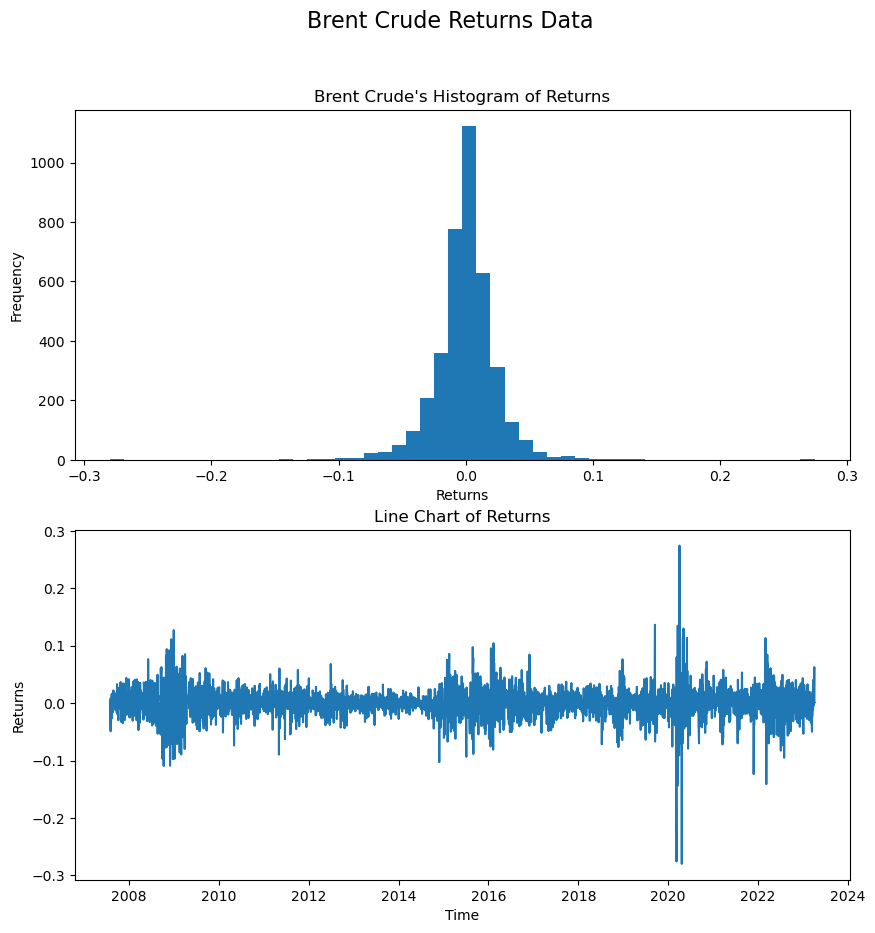

In [4]:
pre_process_plot(data_brent, "Brent Crude")

In [8]:
adfuller(data_brent['returns'].dropna())
# We can see that the return series is stationary (as the p-value of the ADFuller test is close to 0) and the model can be fit on it.

(-9.15854668702126,
 2.5700980590501575e-15,
 29,
 3849,
 {'1%': -3.432050095218107,
  '5%': -2.8622912088149346,
  '10%': -2.5671698778383862},
 -17580.946643190866)

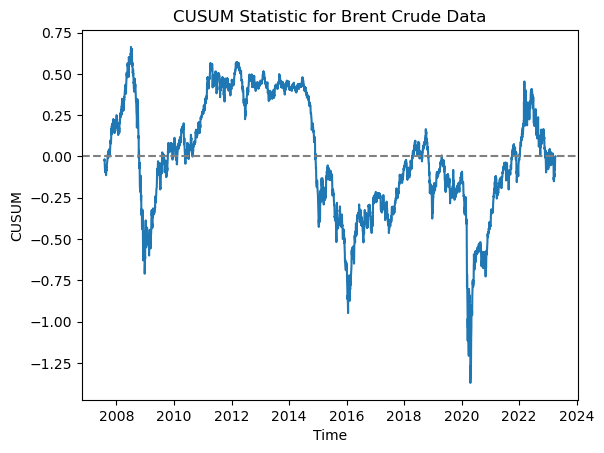

In [11]:
CUSUM_test_plot(data_brent, "Brent Crude")

In [13]:
brent_model_1 = train_model(data_brent)
print(brent_model_1.summary())
print(brent_model_1.expected_durations)

                        Markov Switching Model Results                        
Dep. Variable:                returns   No. Observations:                 3879
Model:               MarkovRegression   Log Likelihood                9693.005
Date:                Tue, 11 Apr 2023   AIC                         -19362.011
Time:                        20:32:49   BIC                         -19286.851
Sample:                             0   HQIC                        -19335.327
                               - 3879                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.000      4.610      0.000       0.001       0.002
sigma2         0.0001      1e-05     13.867      0.0

          Date  Predicted   returns
0   2022-10-14  -0.000826 -0.031582
1   2022-10-17  -0.000708 -0.000109
2   2022-10-18  -0.000653 -0.017507
3   2022-10-19  -0.000571  0.026092
4   2022-10-20  -0.000384 -0.000325
..         ...        ...       ...
115 2023-03-30  -0.000811  0.012568
116 2023-03-31  -0.000839  0.006288
117 2023-04-03  -0.000908  0.062680
118 2023-04-04  -0.000702  0.000118
119 2023-04-05  -0.000606  0.000588

[120 rows x 3 columns]


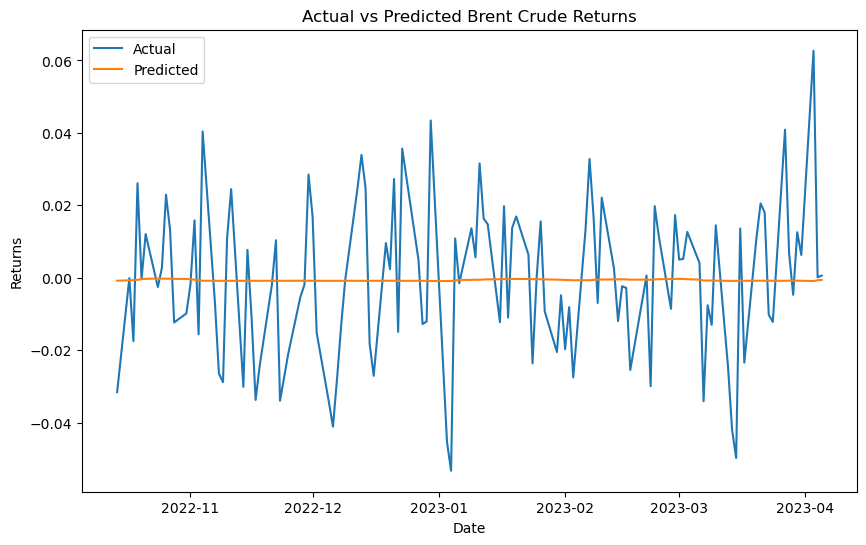

In [14]:
model_viz(brent_model_1, data_brent, "Brent Crude")

In [15]:
brent_model_2 = train_model(data_brent, True)
print(brent_model_2.summary())
print(brent_model_2.expected_durations)

                        Markov Switching Model Results                        
Dep. Variable:                returns   No. Observations:                 3879
Model:               MarkovRegression   Log Likelihood               12728.687
Date:                Tue, 11 Apr 2023   AIC                         -25413.375
Time:                        21:14:40   BIC                         -25275.581
Sample:                             0   HQIC                        -25364.454
                               - 3879                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.482      0.138      -0.000       0.001
x1          8.428e-05      0.000      0.596      0.5

          Date  Predicted   returns
0   2022-10-14  -0.033827 -0.031582
1   2022-10-17  -0.001149 -0.000109
2   2022-10-18  -0.022372 -0.017507
3   2022-10-19   0.017656  0.026092
4   2022-10-20  -0.001609 -0.000325
..         ...        ...       ...
115 2023-03-30   0.013474  0.012568
116 2023-03-31   0.006550  0.006288
117 2023-04-03   0.057080  0.062680
118 2023-04-04   0.001749  0.000118
119 2023-04-05  -0.001368  0.000588

[120 rows x 3 columns]


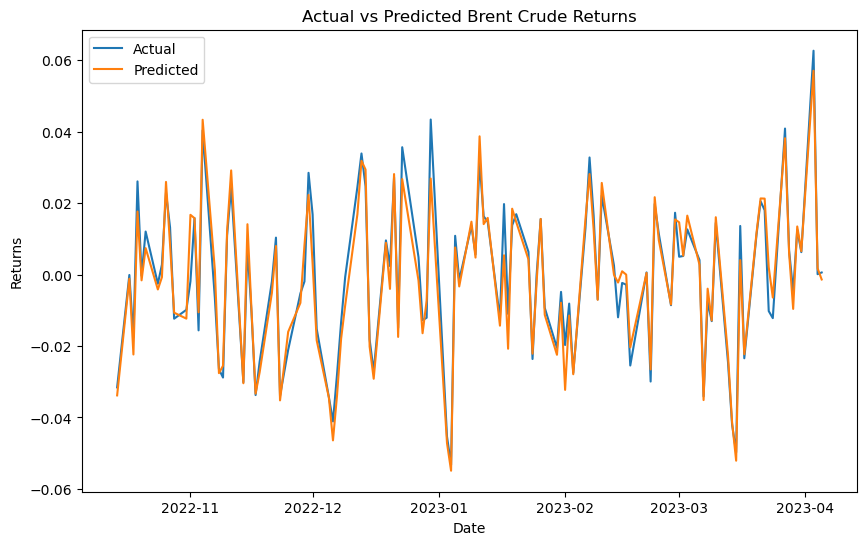

In [16]:
model_viz(brent_model_2, data_brent, "Brent Crude")

In [5]:
data_meta = data_prep("META") # # Brent curde oil
data_meta.tail()

[*********************100%***********************]  1 of 1 completed


,High,Low,Open,Adj Close,Volume,returns,volumeGap,dailyChange,fractHigh,fractLow,forecastVariable
Date,,,,,,,,,,,
2023-04-03,213.490005,208.199997,208.839996,213.070007,17924600,0.005318,-0.349047,0.020255,0.022266,0.003065,1.649994
2023-04-04,216.240005,212.539993,213.389999,214.720001,21026400,0.007714,0.159605,0.006233,0.013356,0.003983,-3.240005
2023-04-05,215.190002,209.940002,214.149994,211.479996,19396600,-0.015204,-0.080681,-0.012468,0.004856,0.019659,4.620010
2023-04-06,216.940002,208.649994,209.250000,216.100006,26104400,0.021611,0.297006,0.032736,0.036750,0.002867,-1.350006
2023-04-10,215.660004,210.660004,214.710007,214.750000,15842000,-0.006267,-0.499439,0.000186,0.004425,0.018863,0.169998


count    2738.000000
mean        0.000673
std         0.025585
min        -0.306391
25%        -0.010160
50%         0.000921
75%         0.012669
max         0.259371
Name: returns, dtype: float64


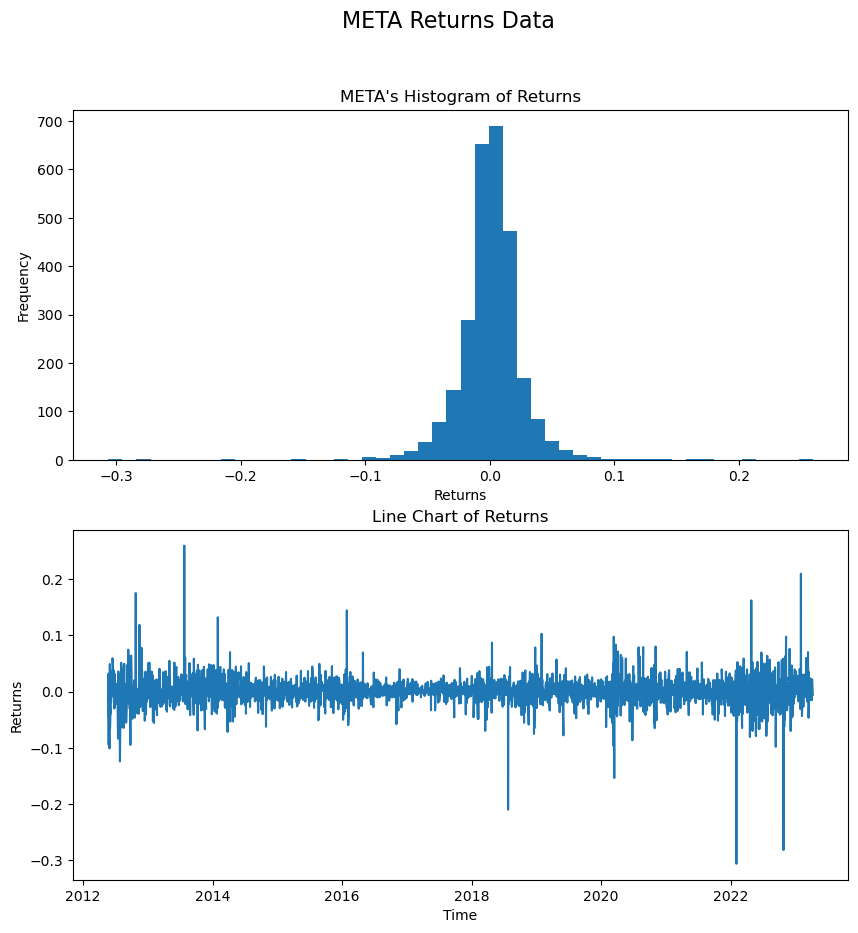

In [7]:
pre_process_plot(data_meta, "META")

In [8]:
adfuller(data_meta['returns'].dropna())
# We can see that the return series is stationary (as the p-value of the ADFuller test is close to 0) and the model can be fit on it.

(-16.46694225298612,
 2.3021249169594227e-29,
 10,
 2727,
 {'1%': -3.432750244284443,
  '5%': -2.8626004539809906,
  '10%': -2.567334514143628},
 -12219.476035121505)

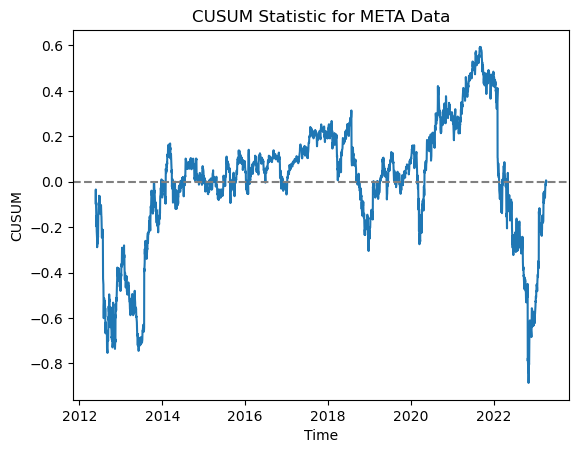

In [12]:
CUSUM_test_plot(data_meta, "META")

In [20]:
meta_1_model = train_model(data_meta, True)
print(meta_1_model.summary())
print(meta_1_model.expected_durations)

                        Markov Switching Model Results                        
Dep. Variable:                returns   No. Observations:                 2737
Model:               MarkovRegression   Log Likelihood                8285.209
Date:                Tue, 11 Apr 2023   AIC                         -16526.418
Time:                        11:20:04   BIC                         -16396.296
Sample:                             0   HQIC                        -16479.394
                               - 2737                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.000      6.907      0.000       0.002       0.004
x1            -0.0005      0.001     -0.887      0.3

          Date  Predicted   returns
0   2022-10-14  -0.034320 -0.027467
1   2022-10-17   0.037127  0.055843
2   2022-10-18  -0.031408 -0.009294
3   2022-10-19  -0.001817  0.003233
4   2022-10-20  -0.015780 -0.012842
..         ...        ...       ...
115 2023-03-31   0.022537  0.019535
116 2023-04-03   0.020006  0.005318
117 2023-04-04   0.006619  0.007714
118 2023-04-05  -0.011937 -0.015204
119 2023-04-06   0.030375  0.021611

[120 rows x 3 columns]


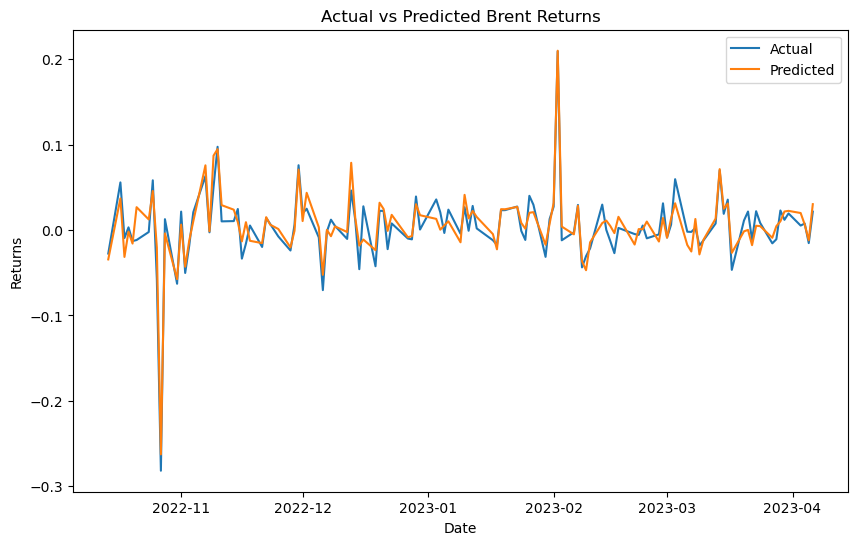

In [21]:
model_viz(meta_1_model, data_meta)